<a href="https://colab.research.google.com/github/laurence-lin/Working-files/blob/main/test_txt_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import glob
import os

from tensorflow.keras.applications import ResNet50
import cv2

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

import time
import gc

import torch
import torchvision



print('Library imported.')


Library imported.


In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
# HYPER PARAMETERS SETTING
import pickle

# Calculate width-height ratio to resize image with same scaling
IMG_PATH = glob.glob('/content/drive/MyDrive/binary_data/train/normal/*.png')
MODEL_PATH = '/content/drive/MyDrive/pretrained_txt_overlap_model/resnet34_new.pickle'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Current device: ', device)



Current device:  cuda:0


In [17]:
from PIL import Image
# Load model and dataset

# Load pre-trained model
with open(MODEL_PATH, 'rb') as f:
  pre_model = pickle.load(f)

print('Pre-trained model loaded.')

# Data-transformer
# Define data augmentation and data loader
from torchvision import transforms

# Define data augmentation methods
data_preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(0.456, 0.225)
    ])



# Preprocess image for PyTorch data architecture
def process_for_model(img):
  '''
  Process image array for PyTorch model
  img: image path string
  return: Tensor image prepared to input to the model
  '''
  img = Image.open(img).convert('RGB')
  img = data_preprocess(img) # remember to do data preprocessing as in the training stage!! This strongly influence the testing performance
  img = img.to(device)
  img = img.view(1, 3, 889, 929)

  return img



Pre-trained model loaded.


In [6]:

def compare_list(y_pred, y_true):
  '''
  Compare prediction and true label of two list
  '''

  result = [1 if (x1 == x2) else 0 for x1, x2 in zip(y_pred, y_true)]
  return result



In [7]:
# Test pre-trained model performance

print('Test pre-trained model performance...')

# Test the model performance

normal_path = glob.glob('/content/drive/MyDrive/binary_data/val/normal/*.png')
overlap_path = glob.glob('/content/drive/MyDrive/binary_data/val/overlap/*.png')

test_path = normal_path + overlap_path
labels = [1 if 'add' in file else 0 for file in test_path]

label_dict = {0:'normal', 1:'overlap'}

print('Start testing prediction...')

predictions = []
for i in range(len(test_path)):
  img = process_for_model(test_path[i]) # data preprocessing

  predict = pre_model(img).cpu().detach().numpy().argmax() # make prediction
  predictions.append(predict)


print('Finish testing prediction.')

compare_result = np.array(compare_list(predictions, labels))
accuracy = compare_result.sum() / len(compare_result)


print('Overall accuracy: ', accuracy)





Test pre-trained model performance...
Start testing prediction...
Finish testing prediction.
Overall accuracy:  1.0


In [ ]:
pre_model

In [10]:
!pip install pytorch-gradcam

In [18]:
from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp
from torchvision.utils import make_grid, save_image

pre_model = pre_model.to(device).eval()

model_config = dict(model_type='resnet', arch=pre_model, layer_name='layer4')

cams = [[cls.from_config(**model_config) for cls in (GradCAM, GradCAMpp)]]

# feedforward image, calculate GradCAM and gather results
images = []
for gradcam, gradcam_pp in cams:

  mask, _ = gradcam(normed_torch_img)
  heatmap, result = visualize_cam(mask, torch_img)
 
  mask_pp, _ = gradcam_pp(normed_torch_img)
  heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

  images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

grid_image = make_grid(images, nrow=5)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


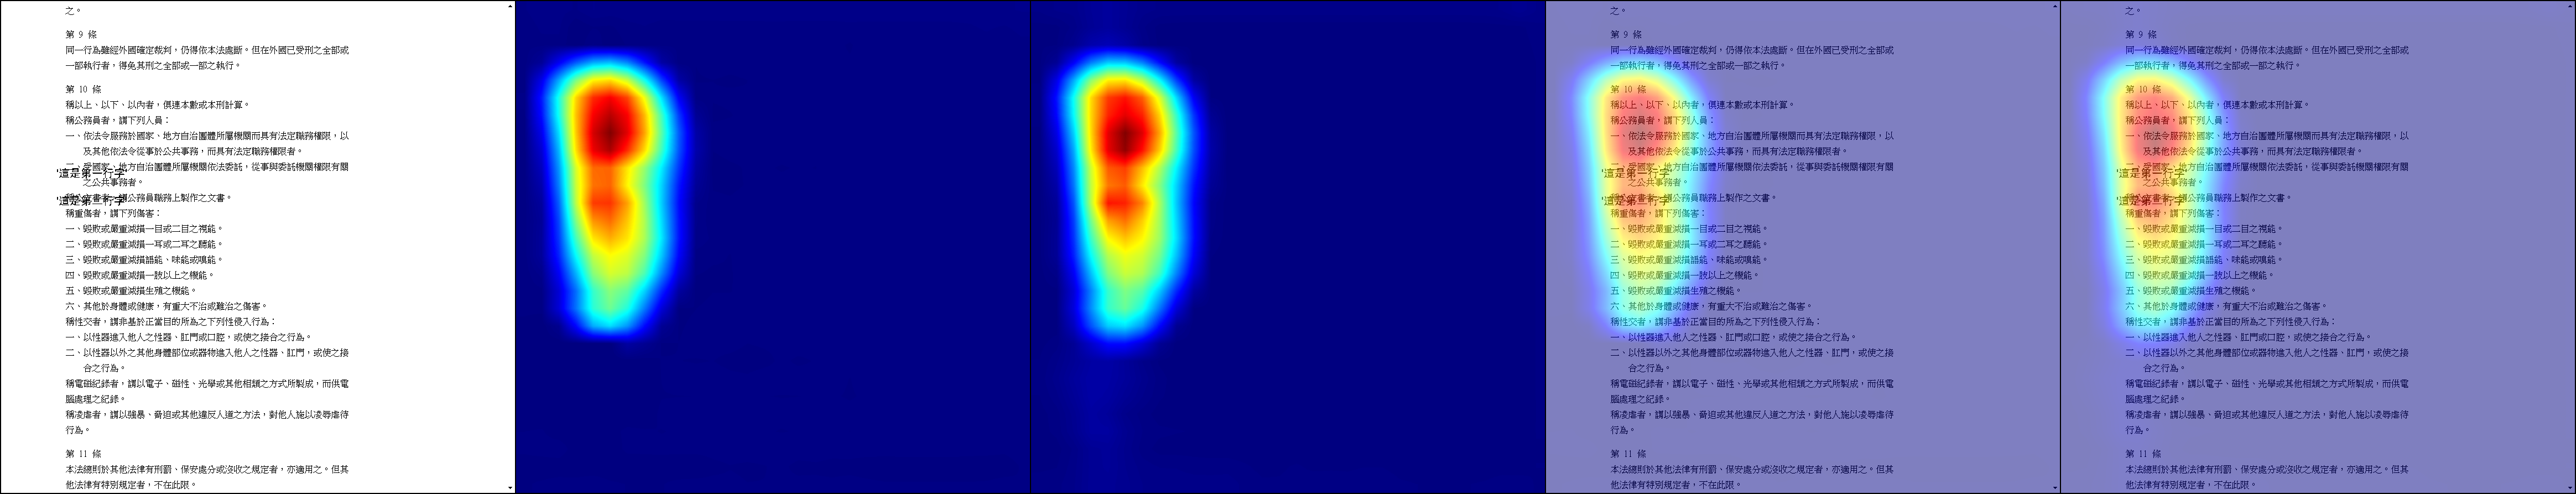

In [19]:
transforms.ToPILImage()(grid_image)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Grid image:  1


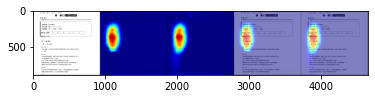

Grid image:  2


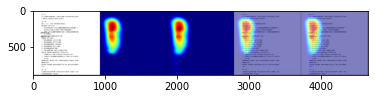

Grid image:  3


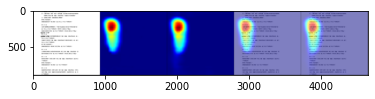

Grid image:  4


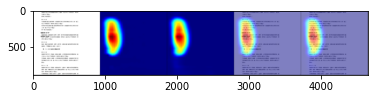

Grid image:  5


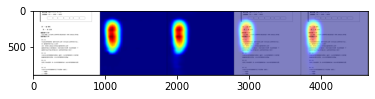

Grid image:  6


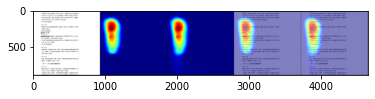

Grid image:  7


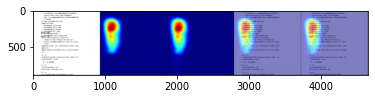

Grid image:  8


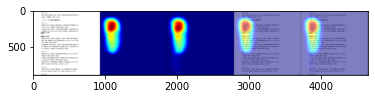

Grid image:  9


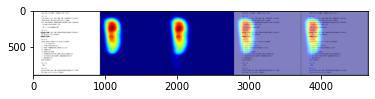

Grid image:  10


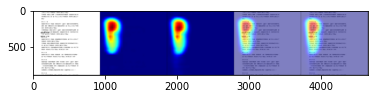

Grid image:  11


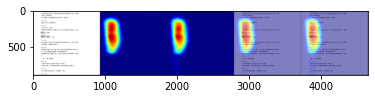

Grid image:  12


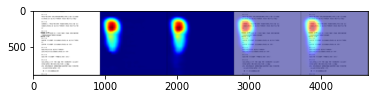

Grid image:  13


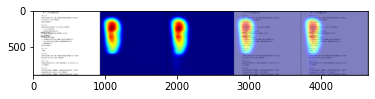

Grid image:  14


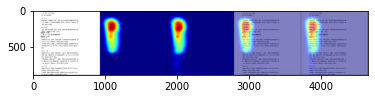

Grid image:  15


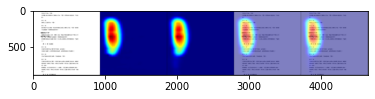

Grid image:  16


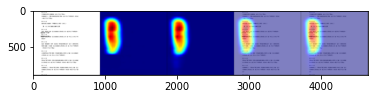

Grid image:  17


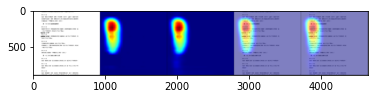

Grid image:  18


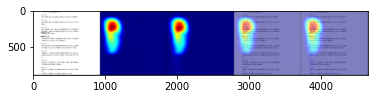

Grid image:  19


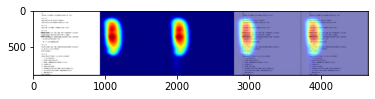

Grid image:  20


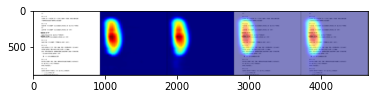

In [25]:
for i in range(20):
  img_path = overlap_path[i]

  pil_img = Image.open(img_path).convert('RGB')
  torch_img = transforms.Compose([
          transforms.ToTensor()
          ])(pil_img).to(device)  
  normed_torch_img = transforms.Normalize(0.456, 0.225)(torch_img)[None]

  images = []
  for gradcam, gradcam_pp in cams:

    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam(mask, torch_img)
 
    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam(mask_pp, torch_img)

    images.extend([torch_img.cpu(), heatmap, heatmap_pp, result, result_pp])

    grid_image = make_grid(images, nrow=5)

    print('Grid image: ', i+1)
    image = transforms.ToPILImage()(grid_image)
    image.save('heatmap_{}.png'.format(i))
    image = np.array(image)
    plt.imshow(image)
    plt.show()

